In [1]:
using LibPQ, Tables, Plots, HTTP, CSV, Random, StatsBase, FreqTables, SQLite, Base, Dates, JuliaDB, StatsPlots, Statistics, 
StructArrays, Distributions, NPFinancial, Random
using Base: show_supertypes
plotly()


┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots /home/sharath/.julia/packages/Plots/qZHsp/src/backends.jl:363


Plots.PlotlyBackend()

In [2]:
import Pkg; Pkg.add("LibPQ"); Pkg.add("Tables"); Pkg.add("Plots"); Pkg.add("HTTP"); Pkg.add("CSV"); Pkg.add("Random"); Pkg.add("StatsBase"); Pkg.add("FreqTables"); Pkg.add("SQLite"); 
 Pkg.add("Dates"); Pkg.add("JuliaDB"); Pkg.add("StatsPlots"); Pkg.add("Statistics"); Pkg.add("StructArrays"); Pkg.add("NPFinancial"); Pkg.add("Distributions");

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes

In [2]:
log(3)

1.0986122886681098

Fact:
let `rd` be the daily rate (not in percentage, but in absolute terms).
then `ry` the yearly rate is given by 
```
ry = (1+rd)^365 - 1
```

and the inverse relationship is 

```
rd = (1+ry)^-365 - 1
```

This is a crazy exponential equation. An yearly rate of `10%` is achived by a daily rate of around `0.03%`

The following graph plots the relation. x axis is daily rate in percentage. y axis is the corresponding yearly rate in percentage

Note also that the maximum negative rate possible is `-100%` at which the initial principal goes to zero.

Note also that from f(0.0%) = 0% to f(0.2%) = 100%, the graph is almost linear, which means that in this region, f(x) ~ x*365

In [3]:
#An example of BigFloat, just in case we need it
# setprecision(BigFloat, 2048) do
#     rd = BigFloat("0.0003")
# #     rd = 0.0003
#     ry = (1+rd)^365 - 1
#     println("ry is  ", ry)
#     rd2 = (1+ry)^(1/365) - 1
#     println("rd2 is    ", rd2)
#     @show rd.prec
# end
rd = -0.01:0.00001:0.01
ry = map(i -> (1+i)^365-1, rd)
1
display(doplot(rd.*100, ry.*100))


LoadError: UndefVarError: doplot not defined

In [4]:
function p2(p1::Number, r::Number, t::Number)
    return Float64(p1)*((1+Float64(r))^Float64(t))
end

function t(p1::Number, p2::Number, r::Number)
    return log(Float64(p2)/Float64(p1)) / log(1+Float64(r))
end

function p1(p2::Number, r::Number, t::Number)
    return Float64(p2)/((1+Float64(r))^Float64(t))
end

function r(p1::Number, p2::Number, t::Number)
    power = log(Float64(p2)/Float64(p1))/Float64(t)
    return exp(power) - 1
end

function emi(p1::Number, r::Number, t::Number)
    x::Float64 = (1.0 + Float64(r))^Float64(t)
    return Float64(p1) * Float64(r) * x / (x - 1)
end
function splt(s, delim=r"\s+")
    ar = split(s, delim)
    ar = strip.(ar)
    ar = filter(s -> s != Missing && length(s)>0, ar)
    return ar
end
conn = LibPQ.Connection("dbname=sharath")
sqlite = SQLite.DB()

SQLite.DB(":memory:")

In [5]:
struct Point
    dates::Array{DateTime}
    prices::Array{Float64}
end


In [ ]:
function getSeries(symbol::String)
    sql = """select date, adjclose from nse_raw nr where symbol = '"""*symbol*"""' and adjclose is not null order by 1 """
    result = execute(conn, sql)
    println(show_supertypes(typeof(result)))
    return result |> table
end
#v2 a linear time algorithm for calculating sip returns. returns an array of returns.
# each element corresponds to a period of sipDurationDays
function sipv2(sipFrequencyDays::Int, sipDurationDays::Int, series)
    series2 = Array{Float64}(undef, 0)
    stocksNow = 0.0
    for i in 1:sipFrequencyDays:length(series)
        append!(series2, series[i])
    end
    n = size(series2)[1]
    rates = Vector{Float64}(undef, 0)
    stocks::Float64 = 0.0
    sipDurationDays = min(n, convert(Int64, floor(sipDurationDays/sipFrequencyDays)))

    
    for i in 1:sipDurationDays
        stocks+=1/series2[i]
    end
    append!(rates, r(sipDurationDays, series[sipDurationDays]*stocks, sipDurationDays/365.0))

    for i in 2:n-sipDurationDays+1
        stocks -= 1/series[i-1]
        stocks += 1/series[i+sipDurationDays-1]
        rate = r(sipDurationDays, series[i+sipDurationDays-1]*stocks, sipDurationDays/365.0)
        append!(rates, r(sipDurationDays, series[i+sipDurationDays-1]*stocks, sipDurationDays/365.0))
    end
    return rates
end
# println(typeof(returns[1, :]))
function gogo(symbol)
    years = 1:7
    returns = Array{Float64}(undef, 101, length(years))

    for year in years
        returns[:, year] = nquantile(sipv2(1, (year)*365, d[symbol].prices), 100).*100
    end
    return plot(collect(1:101), returns, label = permutedims(["year"*string(x) for x in years])) 
end
function constructDict()
    data = columntable(execute(conn, """ select symbol, date, adjclose from nse_raw where date is not null and adjclose is not null order by 1, 2"""))
    symbols = copy(data[1])
    dates = copy(data[2])
    adjclose = copy(data[3])
    d = Dict{String, Point}()
    for i in 1:length(symbols)
        symbol = symbols[i]
        date = dates[i]
        price = adjclose[i]
        if price < 1
            continue
        end
        if !haskey(d, symbol)
            d[symbol] = Point(Array{DateTime}(undef, 0), Array{Float64}(undef, 0))
        end
        point = d[symbol]
        push!(point.dates, dates[i])
        push!(point.prices, max(0, adjclose[i]))
    end
    return d
end
#returns the probablity of a "good" return
# the random experiment is: select an arbitrary start date and do sip for sipDuration
# "good" is defined as yes if the experiment gave an interest more than targetRate
function prob(d::Dict{String, Point}, company::String, sipFrequencyDays::Int, sipDurationDays::Int, targetRate::Float64=0.1)
    series = d[company].prices
    returns = sipv2(sipFrequencyDays::Int, sipDurationDays::Int, series)
    sorted = sort(returns)
    bottom = length(returns)
    top = min(bottom, first(searchsorted(sorted, targetRate)))
    return (bottom-top)/bottom
end

function doplot(d::Dict{String, Point})
    k = collect(keys(d))
    tuples = [(i, prob(d, i, 1, 3*365, 0.1)) for i in k]
    filter(x->x[2]>0.7,sort!( tuples, by=last))
    
    return plot(getindex.(tuples,1), getindex.(tuples, 2))
end
function doplot(x, y)
    plot(x, y; hover=fmt.(x).*"   ".*fmt.(y), size=(1700, 400,))
end

function stock(symbol::String)
    display(plot(d[symbol].dates, d[symbol].prices, title="stock prices"; hover=fmt.(d[symbol].dates).*"   ".*string.(d[symbol].prices), size=(1700, 400,)))
#     display(gogo(symbol))
end

function fti(x::Number)
    return convert(Int64, round(Float64(x)))
end
function fmt(d::DateTime)
    Dates.format(d, "yyyy-mm-dd")
end
function fmt(d::Any)
    string(d)
end

In [7]:
d = constructDict()

Dict{String, Point} with 1660 entries:
  "20MICRONS"  => Point([DateTime("2008-10-06T00:00:00"), DateTime("2008-10-07T…
  "JUBLFOOD"   => Point([DateTime("2010-02-08T00:00:00"), DateTime("2010-02-09T…
  "BAJFINANCE" => Point([DateTime("2004-07-15T00:00:00"), DateTime("2004-07-16T…
  "FLUOROCHEM" => Point([DateTime("2019-10-16T00:00:00"), DateTime("2019-10-17T…
  "RAJSREESUG" => Point([DateTime("2002-07-01T00:00:00"), DateTime("2002-07-02T…
  "SUNDRMBRAK" => Point([DateTime("2002-08-12T00:00:00"), DateTime("2002-08-13T…
  "WHIRLPOOL"  => Point([DateTime("2002-08-12T00:00:00"), DateTime("2002-08-13T…
  "CAREERP"    => Point([DateTime("2010-10-06T00:00:00"), DateTime("2010-10-07T…
  "SUNPHARMA"  => Point([DateTime("1999-12-01T00:00:00"), DateTime("1999-12-02T…
  "TAKE"       => Point([DateTime("2007-08-27T00:00:00"), DateTime("2007-08-28T…
  "VBL"        => Point([DateTime("2016-11-08T00:00:00"), DateTime("2016-11-09T…
  "NOIDATOLL"  => Point([DateTime("2020-11-20T00:00:00")], [6.35])
  "

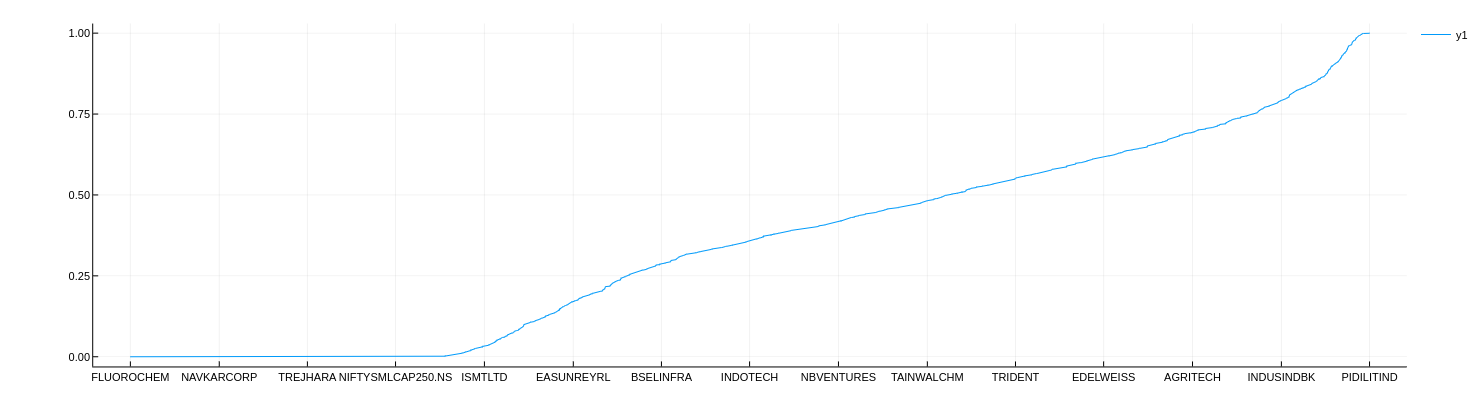

In [9]:
# returns the probability that the sip makes a return of targetRate considering every possible period whose duration is sipDurationDays
doplot(d)
# (filter(x->x[2]<0 , collect(zip(1:length(d["INFY"]), [p.price for p in d["INFY"]]))))
# zip(1:length(d["INFY"]), [p.price for p in d["INFY"]])
# filter(p -> p[1]<0, )
# prob(d, "UJJIVANSFB", 1, 100, 0.1)
# [p.price for p in (d["INFY"][:4])]
# println(([p.price for p in d["INFY"][2000:2010]]))

In [10]:
function companyComparison(p::Float64)
    nn = (symbol=Vector{String}(undef, 0), prob=Vector{Float64}(undef, 0), label=Vector{String}(undef, 0))
    for key in keys(d)
        sss = key
        pp = prob(d, key, 1, 3*365, p)
        label = get(companyToLabel, key, "")
        push!(nn[:symbol], sss)
        push!(nn[:prob], pp)
        push!(nn[:label], label)
    end
    execute(conn, "BEGIN;")
    execute(conn, "drop table if exists work.company_comparison; ")
    execute(conn, """
    create table work.company_comparison (symbol text, prob float, label text)
    """)
    LibPQ.load!(
        nn,
        conn,
        "INSERT INTO work.company_comparison (symbol, prob, label) VALUES (\$1, \$2, \$3);",
    )

    execute(conn, "COMMIT;")
end
companyComparison(0.15)

LoadError: UndefVarError: companyToLabel not defined

In [11]:
prob(d, "TVSMOTOR",1, 3*365, 0.3 )

0.40864984751871364

In [12]:
dt = table(nn)

LoadError: UndefVarError: nn not defined

In [13]:
show_supertypes(typeof(data.NDP_Date))

LoadError: UndefVarError: data not defined

In [14]:
function consecutiveReturns(infp::Array{Float64}, infd::Array{DateTime})
    infi = map(x->convert(Int64, trunc((x-infyd[1]).value/86400000)), infd)
    if length(infi) != length(infp)
        println("fucked   length fo infi is $(length(infi)) and lenth fo infp is $(length(infp)) infd is $(length(infd))")
    end
    ans = Array{Float64}(undef, length(infi)-1)
    for i in 2:length(infp)
        diff = (infi[i]-infi[i-1])
        ans[i-1] = r(infp[i-1], infp[i], (infi[i]-infi[i-1]))*100
    end
#     println(collect(zip(infp, infi, [0; ans])))    
    return ans
end
an = consecutiveReturns(d["BOSCHLTD"].prices, d["BOSCHLTD"].dates)
# println("""prices is $(length(d["BOSCHLTD"].prices)), dates is $(length(d["BOSCHLTD"].dates))""")
# histogram(an)


LoadError: UndefVarError: infyd not defined

In [15]:
x = d["BOSCHLTD"].dates
y = map(x->convert(Int64, trunc((x-infyd[1]).value/86400000)), x)
println("fucked   length fo infi is $(length(x)) and lenth fo infp is $(length(y))")

LoadError: UndefVarError: infyd not defined

In [16]:
df = table((x=an,))
summarize((mean, std), df)


LoadError: UndefVarError: an not defined

In [17]:
function foo()
    sql = """ select symbol from indices i where name = 'nifty-500' """
    result = execute(conn, sql)
    return result |> table
end
df = foo()


Table with 501 rows, 1 columns:
symbol
────────────
"3MINDIA"
"ABB"
"POWERINDIA"
"ACC"
"AIAENG"
"APLAPOLLO"
"AUBANK"
"AARTIDRUGS"
"AARTIIND"
"AAVAS"
"ABBOTINDIA"
"ADANIENT"
⋮
"WELCORP"
"WELSPUNIND"
"WESTLIFE"
"WHIRLPOOL"
"WIPRO"
"WOCKPHARMA"
"YESBANK"
"ZEEL"
"ZENSARTECH"
"ZYDUSWELL"
"ECLERX"

In [18]:
function foo()
    p = Array{Float64}(undef, 0)
    s = Array{String}(undef, 0)
#     println(df[3])
    for fff in df
        symbol = fff[1]
#         x = Array{Float64}(undef, length(df[1]))
#         y = Array{String}(undef, length(df[1]))
#             println(symbol)
        if haskey(d, symbol)
            push!(p, mean(consecutiveReturns(d[symbol].prices, d[symbol].dates)))
            push!(s, symbol)

        end
    end
#     println(y)
    histogram( p,  size=(1700, 400,))

end
foo()


LoadError: UndefVarError: infyd not defined

In [19]:
infyi[1:end]

LoadError: UndefVarError: infyi not defined

In [20]:
function ohlc2()
    function get_ohlc(ticker; kwargs...)
        res = HTTP.get("https://www.quandl.com/api/v3/datasets/WIKI/$(ticker)/data.csv?start_date=2017-01-01")
        df = CSV.read(res.body)
        ohlc(df, x=:Date, open=:Open, high=:High, low=:Low, close=:Close; kwargs...)
    end

    p1 = plot(get_ohlc("AAPL", name="Apple"), Layout(title="Apple"))
    p2 = plot(get_ohlc("GOOG", name="Google"), Layout(title="Google"))

    [p1 p2]
end
ohlc2()

LoadError: ArgumentError: provide a valid sink argument, like `using DataFrames; CSV.read(source, DataFrame)`

In [21]:
death = 100
age = 37
months = (death - age)*12
inflationPerMonth = 6/(100*12)
monthlyCost = 100000
living = monthlyCost * months
println(living)
marriage = 1000000
# education is 100000 per year (present value) starting from 5th year to 5+16 years

education = 16*100000
total = living + marriage + 2*education
println(total)

75600000
79800000


In [22]:
df = CSV.read("/home/sharath/Downloads/AdultDataSet.csv")

LoadError: ArgumentError: provide a valid sink argument, like `using DataFrames; CSV.read(source, DataFrame)`

In [23]:
df2 = df[shuffle(1:nrow(df))[1:Int(floor((nrow(df)/5)))], :]

LoadError: UndefVarError: nrow not defined

In [24]:
plot([histogram(x=randn(10000), opacity=0.75)], Layout(barmode="overlay"))



LoadError: UndefVarError: Layout not defined

In [25]:
filter(row->row["education"]==" HS-grad" && row["marital-status"]==" Never-married", df)

LoadError: MethodError: no method matching getindex(::NamedTuple{(:symbol,), Tuple{Union{Missing, String}}}, ::String)
[0mClosest candidates are:
[0m  getindex(::NamedTuple, [91m::Int64[39m) at namedtuple.jl:117
[0m  getindex(::NamedTuple, [91m::Symbol[39m) at namedtuple.jl:118

In [26]:
typeof(freqtable(df["education"], df["marital-status"]))

LoadError: MethodError: no method matching getindex(::IndexedTable{StructVector{NamedTuple{(:symbol,), Tuple{Union{Missing, String}}}, NamedTuple{(:symbol,), Tuple{LibPQ.Column{Union{Missing, String}}}}, Int64}}, ::String)
[0mClosest candidates are:
[0m  getindex(::IndexedTable, [91m::AbstractVector{var"#s31"} where var"#s31"<:Integer[39m) at /home/sharath/.julia/packages/IndexedTables/tRvfu/src/indexedtable.jl:213
[0m  getindex(::IndexedTable, [91m::Colon[39m) at /home/sharath/.julia/packages/IndexedTables/tRvfu/src/indexedtable.jl:197
[0m  getindex(::IndexedTable, [91m::Integer[39m) at /home/sharath/.julia/packages/IndexedTables/tRvfu/src/indexedtable.jl:196

In [27]:
df |> SQLite.load!(sqlite, "adult")

"adult"

In [28]:
df = DBInterface.execute(sqlite, "select * from adult") |> DataFrame

LoadError: UndefVarError: DataFrame not defined

In [29]:
function f(r1::Float64, r2::Float64, x::Float64)
    return ((1+r1)^x) * ((1+r2)^(1-x)) - 1
end
xx  = 0:0.001:0.99
yy = [f(.04, 0.13, x) for x in ran]
plot(xx, yy, hover=string.(xx).*"   ".*string.(yy), size=(1700, 400,))

LoadError: UndefVarError: ran not defined

# Experimentation on multidimensional array speeds

array iteration speed is about 1 billion per second. insane.

In [30]:
function test(ar::Array{Int64})
    sum = 0
    for i in 1:1000
        for j in 2:length(ar)
            sum+=ar[j]
#             ar[j]+=ar[j-1]
        end
    end
    return sum
end
time_sum(x) = @time test(x);
time_sum(ar)
println(typeof(ar), size(ar))


LoadError: UndefVarError: ar not defined

# Speeds of DataFrames
fucking dataframes is not type stable so it is 100-1000x slower than array iteration and allocates a large amount of memory

There are several table like structures in julia (mostly third parties, several of them seem to be overlapping a lot in functionality)
The best one seems to be IndexedTable. it is type stable. It is implementated as a NamedTuple of vectors but acts like a vector of NamedTuples.
Of course, the fastest and most native is just NamedTuple. But it seems like a NamedTuple (and also IndexedTable) with many columns might stress the compiler (havent tested it)

IndexedTable constructor *copies* the data from the NamedTuple constructor param to create the new IndexedTable. However, invoking `IndexedTable.columns ` returns a NamedTuple *view* of the IndexedTable which is perfect for arbitrary iteration and modifications.

btw, the nomenclature is really fucked up.
- [Julia Data](https://github.com/JuliaDatahttps://github.com/JuliaData) is the name for all built in table like structures in Julia. They all seem to respect the Tables.jl interface
- [JuliaDB](https://juliadata.github.io/JuliaDB.jl/latest/https://juliadata.github.io/JuliaDB.jl/latest/) is one particular table like structure in Julia Data. It is built on `IndexedTables` (seems like both are synonymous). This is the best since it is type stable
- [DataFrames](https://github.com/JuliaData/DataFrames.jlhttps://github.com/JuliaData/DataFrames.jl) is a slow and fucked up implementation in Julia Data. It is feature rich but fucking slow
- [Julia Databases](https://juliadatabases.github.io/https://juliadatabases.github.io/) collects various drivers for different databases like Mysql, postgres, sqlite. seems like all of them can stream to a tables.jl constructor

A good summary of all the shit can be found [here](https://www.juliabloggers.com/a-tour-of-the-data-ecosystem-in-julia/https://www.juliabloggers.com/a-tour-of-the-data-ecosystem-in-julia/) from the author of CSV.jl

In [31]:
function testDataFrame(df::DataFrame)
    ar::Array{Int64} = df.a
    sum = 0
    for i::Int64 in 1:1000
        for j in 1:length(ar)
            sum+=ar[j]
        end
    end
    return sum
end


# println(typeof(df))
time_sum(df) = @time testDataFrame(df);
time_sum(df)


LoadError: UndefVarError: DataFrame not defined

In [32]:
sql = """select symbol , array_agg(name)as names from indices i group by symbol """
result = execute(conn, sql)
println(typeof(result))
df = result |> table


LibPQ.Result


Table with 606 rows, 2 columns:
Columns:
#  colname  type
──────────────────────────────────
1  symbol   Union{Missing, String}
2  names    Union{Missing, String}

In [33]:
l = length(df)
order = splt("""
nifty-50
nifty-next-50
nifty-midcap-50
nifty-midcap-100
nifty-midcap-150
nifty-smallcap-50
nifty-smallcap-100
nifty-smallcap-250

    """)
println(order)
companyToLabel = Dict{String, String}()

for i in 1:l
    company = df[i].symbol
    names = splt(df[i].names[2:end-1], ",")
    for label in order
        if findfirst(x->x==label, names) != nothing
            companyToLabel[company] = label
            @goto label
        end
    end
    companyToLabel[company] = names[1]
    @label label
end

SubString{String}["nifty-50", "nifty-next-50", "nifty-midcap-50", "nifty-midcap-100", "nifty-midcap-150", "nifty-smallcap-50", "nifty-smallcap-100", "nifty-smallcap-250"]


In [34]:
companyToLabel

Dict{String, String} with 606 entries:
  "JUBLFOOD"   => "nifty-midcap-50"
  "BAJFINANCE" => "nifty-50"
  "FLUOROCHEM" => "nifty-smallcap-250"
  "WHIRLPOOL"  => "nifty-midcap-100"
  "SUNPHARMA"  => "nifty-50"
  "VBL"        => "nifty-midcap-100"
  "POLYCAB"    => "nifty-midcap-100"
  "JKCEMENT"   => "nifty-midcap-150"
  "IRCON"      => "nifty-smallcap-100"
  "BHARATRAS"  => "nifty-smallcap-250"
  "SYMPHONY"   => "nifty-midcap-150"
  "IOLCP"      => "nifty-smallcap-250"
  "GRSE"       => "nifty-smallcap-250"
  "ORIENTCEM"  => "nifty-smallcap-250"
  "BPCL"       => "nifty-50"
  "TATAMOTORS" => "nifty-50"
  "WESTLIFE"   => "nifty-smallcap-100"
  "VGUARD"     => "nifty-midcap-100"
  "IFBIND"     => "nifty-smallcap-250"
  "SOLARA"     => "nifty-smallcap-250"
  "TATACOFFEE" => "nifty-smallcap-250"
  "COFORGE"    => "nifty-midcap-50"
  "J&KBANK"    => "nifty-smallcap-250"
  "FOCUS"      => "nifty-sme-emerge"
  "WELSPUNIND" => "nifty-smallcap-100"
  ⋮            => ⋮

In [35]:
data = table((symbol=Vector{String}(undef, 0), company=Vector{String}(undef, 0), prob=Vector{Float64}(undef, 0), label=Vector{String}(undef, 0)))


Table with 0 rows, 4 columns:
symbol  company  prob  label
────────────────────────────

In [36]:
show_supertypes(typeof(rows(data)))

StructVector{NamedTuple{(:symbol, :company, :prob, :label), Tuple{String, String, Float64, String}}, NamedTuple{(:symbol, :company, :prob, :label), Tuple{Vector{String}, Vector{String}, Vector{Float64}, Vector{String}}}, Int64} <: AbstractVector{NamedTuple{(:symbol, :company, :prob, :label), Tuple{String, String, Float64, String}}} <: Any

In [37]:
 sa = StructArray([1+im, 3-2im])

2-element StructArray(::Vector{Int64}, ::Vector{Int64}) with eltype Complex{Int64}:
 1 + 1im
 3 - 2im

In [38]:
tt = table(1:10, randn(10), rand(Bool, 10); names = [:x, :y, :z])


Table with 10 rows, 3 columns:
x   y            z
──────────────────────
1   -0.545254    true
2   1.33202      true
3   -0.00448707  true
4   1.37866      true
5   -1.57017     false
6   -0.41002     false
7   0.591256     true
8   -1.07448     true
9   0.535714     true
10  -0.457229    false

In [39]:
push!(rows(tt), (x=1, y=1.1, z=true))

11-element StructArray(::Vector{Int64}, ::Vector{Float64}, ::Vector{Bool}) with eltype NamedTuple{(:x, :y, :z), Tuple{Int64, Float64, Bool}}:
 (x = 1, y = -0.5452543362680328, z = 1)
 (x = 2, y = 1.3320242892636587, z = 1)
 (x = 3, y = -0.004487072767535794, z = 1)
 (x = 4, y = 1.3786574345427867, z = 1)
 (x = 5, y = -1.570168597559574, z = 0)
 (x = 6, y = -0.4100201440806508, z = 0)
 (x = 7, y = 0.5912555609968398, z = 1)
 (x = 8, y = -1.0744844350223661, z = 1)
 (x = 9, y = 0.5357142329858423, z = 1)
 (x = 10, y = -0.4572289134890392, z = 0)
 (x = 1, y = 1.1, z = 1)

In [40]:
select(tt, :x)

11-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
  1